<a href="https://colab.research.google.com/github/masayuki038/signate-44th-diabetes/blob/main/SIGNATE_44th_%E8%A8%BA%E6%96%AD%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E7%B3%96%E5%B0%BF%E7%97%85%E7%99%BA%E7%97%87%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pycaret==3.2
!pip install --quiet shapely>=2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB

In [2]:
!pip install --quiet catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.6 MB/s eta 0:00:00


# <p style="font-family:newtimeroman;font-size:100%;text-align:center;color:#F52549;">Importing Libraries</p>

In [3]:
# import libraries

# 1. to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# this is for jupyter notebook to show the plot in the notebook itself instead of opening a new window
%matplotlib inline

# To preprocess the data
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler , QuantileTransformer

# machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.multioutput import MultiOutputClassifier
#Model
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

#Evaluation
from sklearn.metrics import roc_auc_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options for maximum columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# <p style="font-family:newtimeroman;font-size:100%;text-align:center;color:#F52549;">Data Loading and Overview</p>

In [4]:
# Load Submission Data
df_submission = pd.read_csv('/var/SIGNATE/44th/sample_submit.csv')
# Load test Data
df_test = pd.read_csv('/var/SIGNATE/44th/test.csv')
# Load Train Dataset and show head of Data
#Train Data
df_train = pd.read_csv('/var/SIGNATE/44th/train.csv')

In [5]:
df_train.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,200,9,125,74,0,0,28.536910,0.444902,45,1
1,3832,4,109,80,0,0,28.047673,0.238243,22,0
2,4927,4,88,78,39,0,52.371341,0.279471,26,0
3,4088,9,125,74,0,0,40.062688,0.203922,45,0
4,3644,5,107,78,44,284,52.935068,0.284959,45,1


In [6]:
test_id = df_test["index"]

# <p style="font-family:newtimeroman;font-size:80%;text-align:center;color:#F52549;">Head Of Datasets</p>

In [7]:
df_submission.head()

,398,0
0,3833,0
1,4836,0
2,4572,0
3,636,0
4,2545,0


In [8]:
# ここから再開
num_train_rows, num_train_columns = df_train.shape

num_test_rows, num_test_columns = df_test.shape

num_submission_rows, num_submission_columns = df_submission.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Submission Data:")
print(f"Number of Rows: {num_submission_rows}")
print(f"Number of Columns: {num_submission_columns}")

Training Data:
Number of Rows: 3000
Number of Columns: 10

Test Data:
Number of Rows: 2000
Number of Columns: 9

Submission Data:
Number of Rows: 1999
Number of Columns: 2


In [9]:
# Null Values in Train
train_null = df_train.isnull().sum().sum()

#Null Count in Test
test_null = df_test.isnull().sum().sum()

#null Count in Submission
submission_null = df_submission.isnull().sum().sum()

print(f'Null Count in Train: {train_null}')
print(f'Null Count in Test: {test_null}')
print(f'Null Count in Submission: {submission_null}')

Null Count in Train: 0
Null Count in Test: 0
Null Count in Submission: 0


In [10]:
# Count duplicate rows in train_data
train_duplicates = df_train.duplicated().sum()

# Count duplicate rows in test_data
test_duplicates = df_test.duplicated().sum()

# Count duplicate rows in original_data
submission_duplicates = df_submission.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in test_data: {submission_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in test_data: 0


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 234.5 KB


In [12]:
df_train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2492.964667,3.557000,113.733667,68.743667,11.164000,11.663333,35.262073,0.400476,28.932000,0.239000
std,1447.218078,3.032131,20.885612,16.332755,14.351159,45.064090,7.568025,0.274666,8.469078,0.426544
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,0.000775,0.145844,21.000000,0.000000
25%,1218.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.301920,0.230987,22.000000,0.000000
50%,2465.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.835873,0.268674,26.000000,0.000000
75%,3750.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.578256,0.506778,33.000000,0.000000
max,4999.000000,13.000000,196.000000,110.000000,49.000000,579.000000,53.400629,2.302072,67.000000,1.000000


In [13]:
# Function to Plot Numerical Distribution With Respect to Target
def plot_numerical_distribution_with_hue(data, num_cols, hue_col, figsize=(60, 30), dpi=300):
    # Create subplots
    fig, ax = plt.subplots(2, 4, figsize=figsize, dpi=dpi)
    ax = ax.flatten()

    # Loop through each column and plot the distribution with hue
    for i, column in enumerate(num_cols):
        print(f'{i}, {column}')
        sns.histplot(data=data, x=column, hue=hue_col, ax=ax[i], kde=True, palette='Set2')
        ax[i].set_title(f'{column} Distribution', size=14)
        ax[i].set_xlabel(None)
        ax[i].set_ylabel(None)

    # Set Tight Layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [14]:
num_cols = ['Pregnancies',	'Glucose',	'BloodPressure',	'SkinThickness',	'Insulin',	'BMI',	'DiabetesPedigreeFunction',	'Age']
#plot_numerical_distribution_with_hue(df_train, num_cols, 'Outcome')

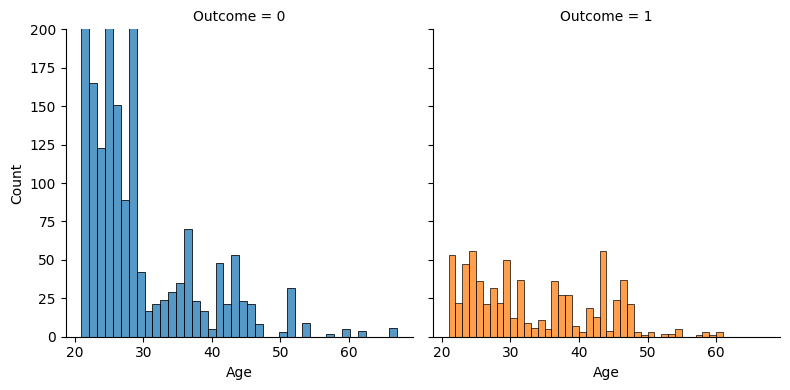

In [15]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
plt.ylim(0, 200)
fig.map(sns.histplot, 'Age', bins=40, kde=False)

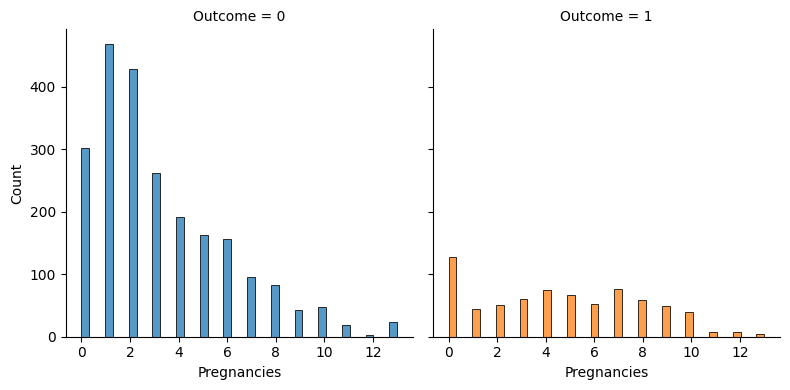

In [16]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
fig.map(sns.histplot, 'Pregnancies', bins=40, kde=False)

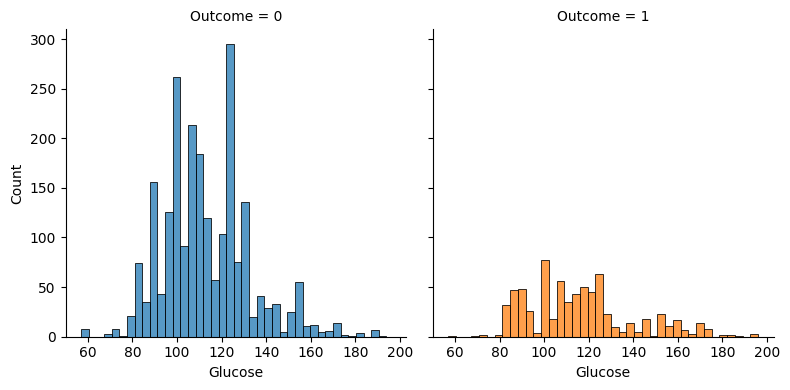

In [17]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
fig.map(sns.histplot, 'Glucose', bins=40, kde=False)

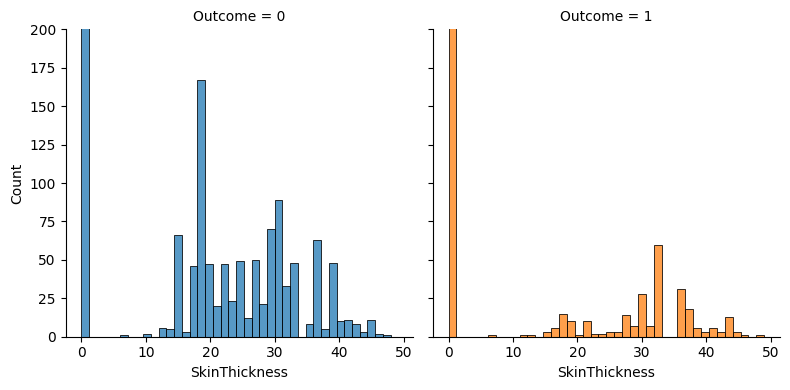

In [18]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
plt.ylim(0, 200)
fig.map(sns.histplot, 'SkinThickness', bins=40, kde=False)

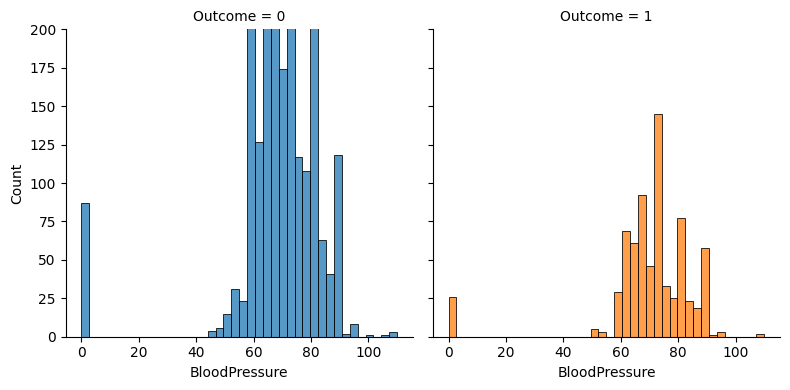

In [19]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
plt.ylim(0, 200)
fig.map(sns.histplot, 'BloodPressure', bins=40, kde=False)

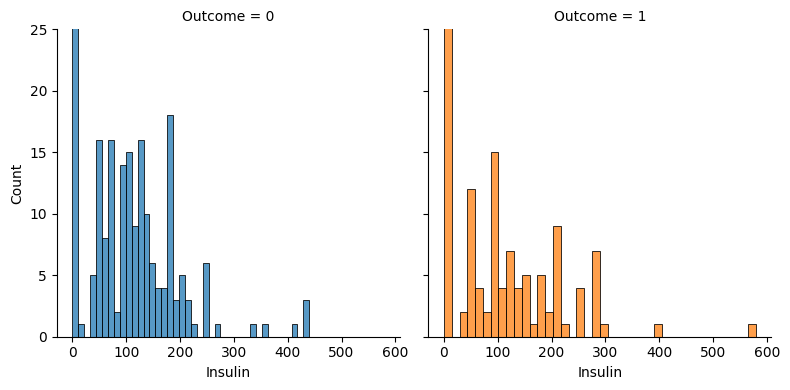

In [20]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
plt.ylim(0, 25)
fig.map(sns.histplot, 'Insulin', bins=40, kde=False)

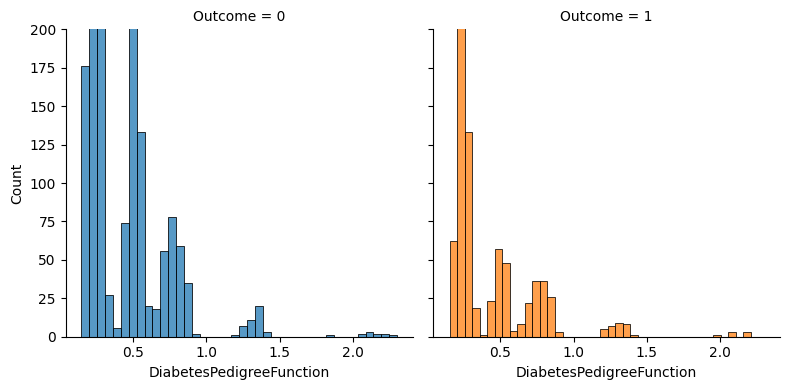

In [21]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
plt.ylim(0, 200)
fig.map(sns.histplot, 'DiabetesPedigreeFunction', bins=40, kde=False)

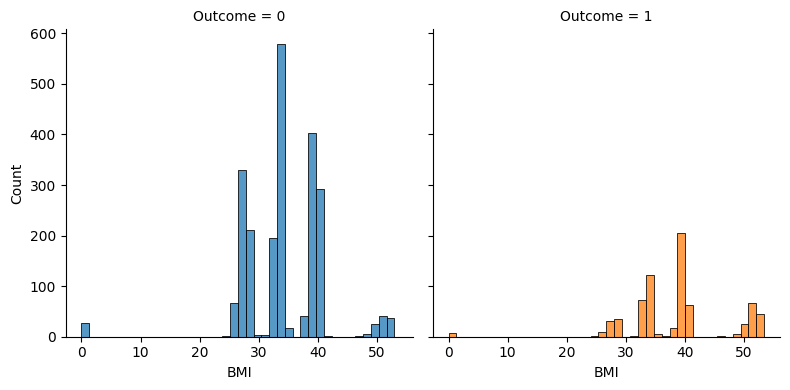

In [22]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
fig.map(sns.histplot, 'BMI', bins=40, kde=False)

In [23]:
#plot_numerical_distribution_with_hue(df_train, num_cols, 'Outcome')

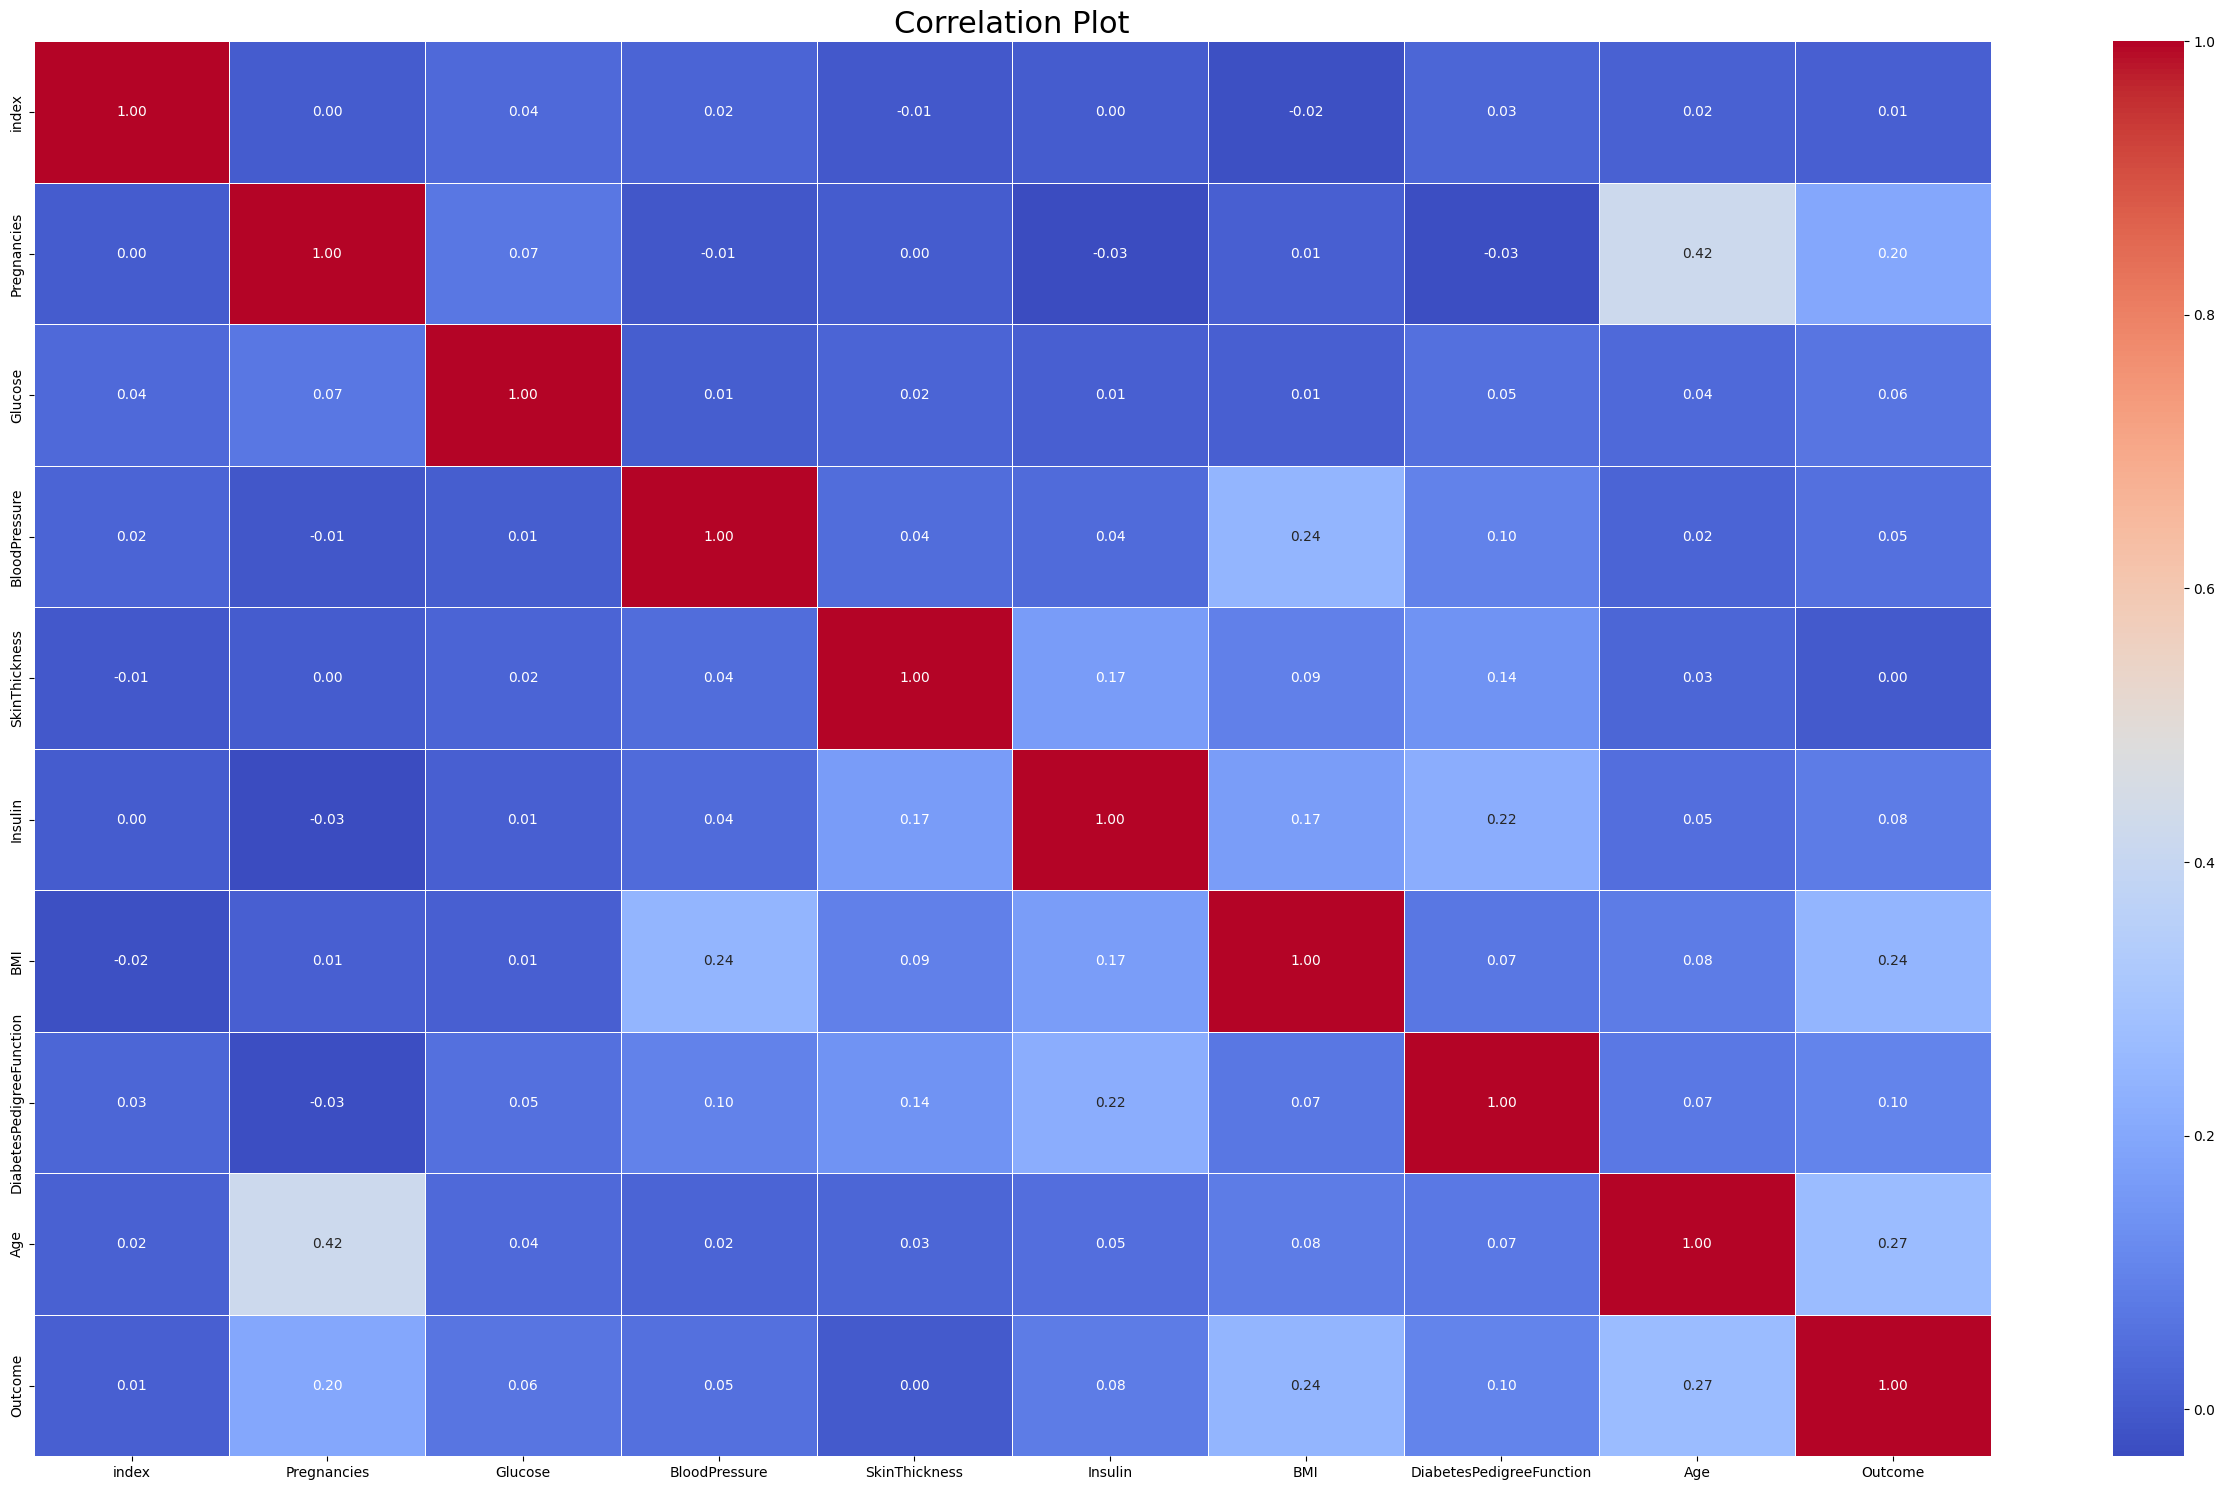

In [24]:
# Select only numeric columns
numeric_df_train = df_train.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df_train.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot', fontsize=22)
plt.tight_layout()
plt.show()

# <p style="font-family:newtimeroman;font-size:100%;text-align:center;color:#F52549;">Correlation Analysis</p>

In [25]:
# Define the correlation threshold
threshold = 0.2

# Extract upper triangular portion of the correlation matrix
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find highly correlated features
highly_correlated = (upper_tri.abs() > threshold).any()

# Get the names of highly correlated features
correlated_features = upper_tri.columns[highly_correlated].tolist()

# Print the names of highly correlated features
print("Highly Correlated Features:")
print(correlated_features)

Highly Correlated Features:
['BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


# <p style="font-family:newtimeroman;font-size:100%;text-align:center;color:#F52549;">Model Building</p>

In [26]:
# Dropping Null Values to | Skips any Error In Next Steps
df_train.dropna(inplace=True)

In [27]:
# Dropping Some Columns From df_train
outcome = df_train['Outcome']
df_train.drop(['index'], axis=1, inplace=True)
df_test.drop(['index'], axis=1, inplace=True)

In [28]:
#train_x, test_x, train_y, test_y = train_test_split(
#    df_train.drop('Outcome', axis=1), outcome, test_size=0.3, random_state=42)

In [29]:
# Shape of Train and Test
print(f"The shape of Train data is {df_train.shape}")
print(f"The shape of Test data is {df_test.shape}")

The shape of Train data is (3000, 9)
The shape of Test data is (2000, 8)


In [30]:
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,9,125,74,0,0,28.536910,0.444902,45,1
1,4,109,80,0,0,28.047673,0.238243,22,0
2,4,88,78,39,0,52.371341,0.279471,26,0
3,9,125,74,0,0,40.062688,0.203922,45,0
4,5,107,78,44,284,52.935068,0.284959,45,1


In [31]:
df_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,126,80,0,0,40.096264,0.822517,21
1,3,88,60,20,0,39.810590,0.204331,22
2,3,114,76,0,0,33.198760,0.521011,21
3,1,146,74,0,0,26.890259,0.504950,38
4,1,123,90,26,140,40.270088,0.800513,28


In [32]:
#train_x.head()

In [33]:
#train_y.head()

In [34]:
# clean up

# 本来、Insulin が高ければ糖尿病の傾向は高まるはずだが、ヒストグラムを見る限りその傾向は見られないので削除
#df_train.drop(['Insulin'], axis=1, inplace=True)
#df_test.drop(['Insulin'], axis=1, inplace=True)

# SkinThickness も相関が見られないので削除
df_train.drop(['SkinThickness'], axis=1, inplace=True)
df_test.drop(['SkinThickness'], axis=1, inplace=True)

In [35]:
#df_train[df_train['SkinThickness'] != 0]
df_train = df_train[df_train['BloodPressure'] != 0]

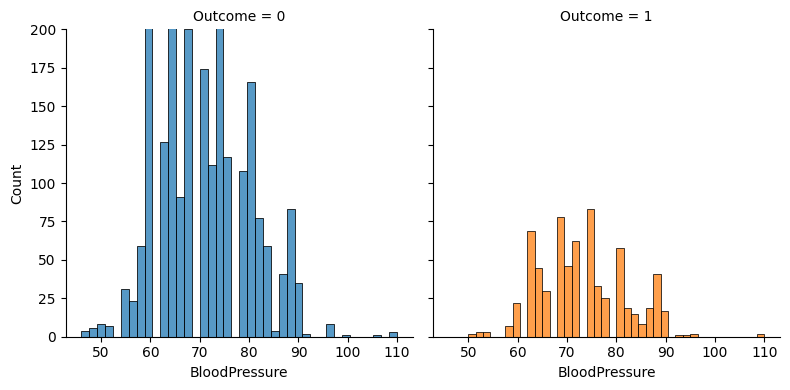

In [36]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
plt.ylim(0, 200)
fig.map(sns.histplot, 'BloodPressure', bins=40, kde=False)

In [37]:
df_train = df_train[df_train['BMI'] > 20.0]

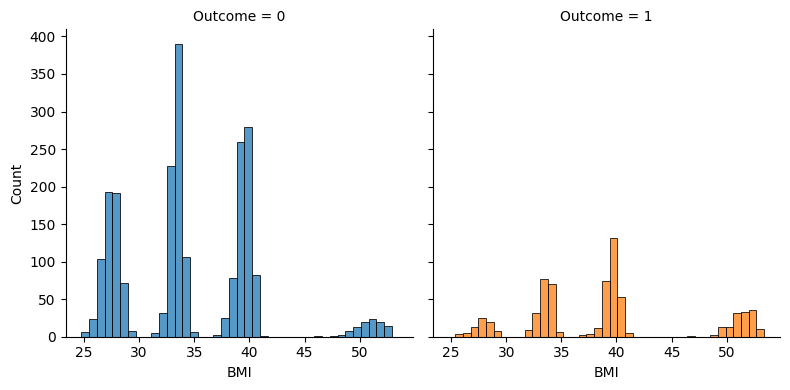

In [38]:
fig = sns.FacetGrid(df_train, col='Outcome', hue='Outcome', height=4)
fig.map(sns.histplot, 'BMI', bins=40, kde=False)

In [39]:
# feature engineering

# ビンの範囲をリストで指定
age_bins = [0, 19, 39, 59, 79, 89]

# pd.cut を使用して離散的なカテゴリに変換
#df_train['Age_C'] = pd.cut(df_train['Age'], bins=age_bins, labels=['<20', '20<40', '40<60', '60<80', '80<'])
#df_test['Age_C'] = pd.cut(df_test['Age'], bins=age_bins, labels=['<20', '20<40', '40<60', '60<80', '80<'])

# ビンの範囲をリストで指定
bmi_bins = [10, 19.99, 29.99, 39.99, 100]

# pd.cut を使用して離散的なカテゴリに変換
#df_train['BMI_C'] = pd.cut(df_train['BMI'], bins=bmi_bins, labels=['10.00-19.99', '20.00-29.99', '30.00-39.99', '40.00-100.00'])
#df_test['BMI_C'] = pd.cut(df_test['BMI'], bins=bmi_bins, labels=['10.00-19.99', '20.00-29.99', '30.00-39.99', '40.00-100.00'])

# "age"列と"bmi"列の値を足して新しい列"age+bmi"を作成
#df_train['age+preg'] = df_train['Age'] + ((df_train['Pregnancies'] * 4) + 10)
#df_train.drop(['Age', 'BMI'], axis=1, inplace=True)

#df_test['age+preg'] = df_test['Age'] + ((df_test['Pregnancies'] * 4) + 10)
#df_test.drop(['Age', 'BMI'], axis=1, inplace=True)

df_train.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,9,125,74,0,28.536910,0.444902,45,1
1,4,109,80,0,28.047673,0.238243,22,0
2,4,88,78,0,52.371341,0.279471,26,0
3,9,125,74,0,40.062688,0.203922,45,0
4,5,107,78,284,52.935068,0.284959,45,1


In [40]:
# normalization

# Normalizations Using Quantile Transformer
# Intlizer QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')

#cols_for_normal = ['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']
cols_for_normal = ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'BMI']
# Fit and Transform
for col in cols_for_normal:
    df_train[col] = qt.fit_transform(df_train[[col]])
for col in cols_for_normal:
    df_test[col] = qt.fit_transform(df_test[[col]])

In [41]:
df_train.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.505747,0.716839,0.312376,-5.199338,-0.793062,0.354287,1.521525,1
1,0.338834,-0.099274,0.877196,-5.199338,-0.940432,-0.522109,-0.871679,0
2,0.338834,-1.391202,0.668987,-5.199338,2.265661,0.120216,0.047692,0
3,1.505747,0.716839,0.312376,-5.199338,1.020544,-1.334761,1.521525,0
4,0.571638,-0.244548,0.668987,2.611712,2.865647,0.163210,1.521525,1


# <p style="font-family:newtimeroman;font-size:100%;text-align:center;color:#F52549;">LightBoost | PyCaret </p>

![image.png](attachment:3447685d-37cc-40f9-8f77-236f02f8608c.png)

In [42]:
TARGET = 'Outcome'
# Import
from pycaret.classification import *
# Setup
clf1 = setup(data=df_train, target=TARGET)

,Description,Value
0,Session id,1890
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(2878, 8)"
4,Transformed data shape,"(2878, 8)"
5,Transformed train set shape,"(2014, 8)"
6,Transformed test set shape,"(864, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [43]:
 best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7959,0.7979,0.3568,0.6270,0.4525,0.3397,0.3608,2.5330
ada,Ada Boost Classifier,0.7934,0.7837,0.3859,0.6088,0.4694,0.3500,0.3653,0.2470
gbc,Gradient Boosting Classifier,0.7855,0.7954,0.3296,0.5879,0.4213,0.3033,0.3225,0.2700
rf,Random Forest Classifier,0.7805,0.7769,0.3278,0.5671,0.4132,0.2915,0.3085,0.3660
et,Extra Trees Classifier,0.7771,0.7638,0.2739,0.5721,0.3683,0.2537,0.2798,0.2880
lightgbm,Light Gradient Boosting Machine,0.7770,0.7819,0.3858,0.5465,0.4516,0.3173,0.3251,0.3950
lr,Logistic Regression,0.7726,0.7156,0.1518,0.5783,0.2376,0.1587,0.2067,1.1810
xgboost,Extreme Gradient Boosting,0.7726,0.7715,0.3963,0.5356,0.4538,0.3147,0.3212,0.1110
ridge,Ridge Classifier,0.7716,0.0000,0.0831,0.6964,0.1477,0.1019,0.1819,0.0270
lda,Linear Discriminant Analysis,0.7696,0.7151,0.1289,0.5665,0.2086,0.1354,0.1854,0.0320


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [44]:
print(best)

In [45]:
model = create_model('lightgbm')
#tuned_model = model
tuned_model = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7772,0.7846,0.4286,0.5526,0.4828,0.3437,0.3482
1,0.7673,0.7683,0.3878,0.5278,0.4471,0.3041,0.3099
2,0.8119,0.8588,0.4375,0.6562,0.5250,0.4135,0.4267
3,0.7772,0.7810,0.3542,0.5484,0.4304,0.2998,0.3109
4,0.7264,0.7139,0.2292,0.3793,0.2857,0.1290,0.1353
5,0.7711,0.7806,0.3958,0.5278,0.4524,0.3114,0.3166
6,0.7761,0.7489,0.3958,0.5429,0.4578,0.3211,0.3275
7,0.7413,0.7127,0.3125,0.4412,0.3659,0.2093,0.2142
8,0.7960,0.8035,0.3958,0.6129,0.4810,0.3613,0.3747


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8267,0.8037,0.3673,0.8182,0.5070,0.4198,0.4695
1,0.7822,0.8021,0.4082,0.5714,0.4762,0.3435,0.3512
2,0.8515,0.8417,0.5208,0.7812,0.6250,0.5370,0.5541
3,0.7822,0.7542,0.2917,0.5833,0.3889,0.2739,0.2982
4,0.7662,0.7424,0.2500,0.5217,0.3380,0.2169,0.2385
5,0.8109,0.8185,0.4167,0.6667,0.5128,0.4032,0.4203
6,0.7960,0.7492,0.4167,0.6061,0.4938,0.3715,0.3818
7,0.7711,0.7609,0.2917,0.5385,0.3784,0.2530,0.2709
8,0.8109,0.8355,0.4375,0.6562,0.5250,0.4128,0.4260


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [46]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [47]:
# Finalize Model
f_model = finalize_model(tuned_model)

In [48]:
# Best Model Prediction
predict_model(f_model,
              round = 10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8275462963,0.8217891308,0.3864734300,0.7843137255,0.5177993528,0.4271984623,0.4669281870


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,prediction_label,prediction_score
1263,-0.256198,-1.029375,-1.327982,-5.199337,-1.169710,-0.927159,-0.871679,0,0,0.987602
535,-0.256198,2.033104,0.877196,-5.199337,0.336365,-1.315858,0.459820,0,0,0.758653
411,0.084155,-1.761948,1.414698,-5.199337,-0.868719,-1.565343,0.459820,1,0,0.715247
506,0.338834,0.094232,-0.699108,-5.199337,1.347448,0.558309,1.114033,0,0,0.679378
601,-0.734798,0.493553,-0.975466,-5.199337,0.938457,0.036987,-0.871679,0,0,0.831822
...,...,...,...,...,...,...,...,...,...,...
786,-0.256198,2.056779,2.651732,-5.199337,-1.397012,1.194659,-0.871679,0,0,0.953199
2801,-0.256198,0.008782,-0.066541,-5.199337,-1.648435,0.265350,0.301855,0,0,0.976153
800,-0.734798,0.094232,-0.287442,-5.199337,1.005565,-0.807843,-0.871679,0,0,0.942213
1157,-0.734798,-0.395204,-1.327982,-5.199337,0.117992,0.591335,-0.871679,0,0,0.967747


In [49]:
# Evaluate Best Final Model
evaluate_model(f_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

https://github.com/scipy/scipy/blob/v1.10.1/scipy/_lib/_util.py#L153
上記を見る限り、prod は scipy v1.10.1 に存在しているように見える

In [50]:
#df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
#inf_presence = df_test.isin([np.inf, -np.inf]).values.any()
#print(inf_presence)

In [51]:
# Making Prediction DataFrame
p_Light = predict_model(f_model,
                        data=df_test,
                        raw_score=True,
                        round = 10
                       )
# Head Prediction _df
p_Light.head(3)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,prediction_label,prediction_score_0,prediction_score_1
0,-5.199337,0.785036,0.918498,-5.199337,0.964630,1.606909,-5.199337,0,0.753541,0.246459
1,0.084155,-1.397837,-1.137677,-5.199337,0.762879,-1.404451,-0.901416,0,0.669094,0.330906
2,0.084155,0.128317,0.568686,-5.199337,-0.398724,0.779172,-5.199337,0,0.922236,0.077764


In [52]:
p_Light['Outcome'] =p_Light.apply(
    lambda row: 0 if (row['prediction_score_0'] > row['prediction_score_1']) else 1,
    axis=1
)

In [53]:
p_Light.head(3)

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,prediction_label,prediction_score_0,prediction_score_1,Outcome
0,-5.199337,0.785036,0.918498,-5.199337,0.964630,1.606909,-5.199337,0,0.753541,0.246459,0
1,0.084155,-1.397837,-1.137677,-5.199337,0.762879,-1.404451,-0.901416,0,0.669094,0.330906,0
2,0.084155,0.128317,0.568686,-5.199337,-0.398724,0.779172,-5.199337,0,0.922236,0.077764,0


In [54]:
# Making Submission DF
submission_df = pd.DataFrame({
    'index': test_id,
    'Outcome': p_Light['Outcome']
})
# Head Submission
submission_df.head(5)

,index,Outcome
0,398,0
1,3833,0
2,4836,0
3,4572,0
4,636,0


In [55]:
# Submission Save
submission_df.to_csv("/var/SIGNATE/44th/submission.csv", header=False, index=False)